In [2]:
import numpy as np
import pandas as pd
import h5py
from scipy.io import loadmat
from cvxopt import solvers, matrix
solvers.options['show_progress'] = False
from universal.algo import Algo
from universal import algos, tools
import logging
# we would like to see algos progress
logging.basicConfig(format='%(asctime)s %(message)s', level = logging.DEBUG)

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
mpl.rcParams['figure.figsize'] = (18, 8)
default_color_cycle = mpl.rcParams['axes.prop_cycle'] # save this as we will want it back later
from cycler import cycler
plt.style.use('seaborn')
sns.set(context = 'notebook', style = 'white', font_scale = 1.5)

2019-06-03 11:25:00,154 backend module://ipykernel.pylab.backend_inline version unknown


# Data Ingestion

In [3]:
path = '../../data/olps/'
datasets = ['nyse-o', 'nyse-n', 'djia', 'tse', 'sp500', 'msci']

all_data = {}
prices = {}

for dataset in datasets:
    try:
        all_data[dataset] = loadmat(path + dataset + '.mat')['data']
    except NotImplementedError:
        f = h5py.File(path + dataset + '.mat')
        all_data[dataset] = np.array(f.items()[0][1]).T
    
    T, n = all_data[dataset].shape
    prices[dataset] = np.empty((T+1, n), dtype = np.float64)
    prices[dataset][0] = 1.
    prices[dataset][1:, :] = np.cumprod(all_data[dataset], axis = 0)

In [35]:
etfs = [
    'VTI', 'EFA', 'EEM', 'TLT', 'TIP', 'VNQ',
#     'IEF', 'GLD', 'DBC',
]
path = '/home/asalas/dphil/thesis/data/'

etf_data = {
    etf: pd.read_csv(path + etf + '.csv', index_col = 0, parse_dates = True)
    for etf in etfs
}

S = pd.DataFrame({
    etf: data['Adj Close'] for etf, data in etf_data.iteritems()
})

S.dropna(inplace = True)

# create other frequencies
mS = S.resample('M').last()
wS = S.resample('W').last()
qS = S.resample('Q').last()
yS = S.resample('Y').last()

In [36]:
S.tail()

,EEM,EFA,TIP,TLT,VNQ,VTI
Date,,,,,,
2019-05-28,40.090000,64.150002,113.338203,128.436417,87.190002,143.309998
2019-05-29,40.349998,63.740002,113.537094,128.825607,86.029999,142.330002
2019-05-30,40.570000,63.980000,113.914993,129.933334,86.389999,142.610001
2019-05-31,40.709999,63.400002,114.630997,131.559998,86.889999,140.690002
2019-06-03,41.080002,63.770000,114.940002,132.440002,87.099998,140.410004


In [37]:
S.head()

,EEM,EFA,TIP,TLT,VNQ,VTI
Date,,,,,,
2004-09-29,14.526196,31.204691,67.025826,53.196068,25.657133,40.478073
2004-09-30,14.602382,31.315432,67.019417,52.991890,25.863012,40.545807
2004-10-01,14.881737,31.802668,66.704239,52.727203,26.341665,41.200489
2004-10-04,15.135693,31.851377,66.543449,52.805576,26.454901,41.335941
2004-10-05,15.023946,31.869101,66.717110,52.805576,26.449747,41.324665


# OLMAX Motivation

In [ ]:
# def max_util(r):
#     r_max = max(r)
    
#     if r_max > 0:
#         return np.log(1 + r_max)
    
#     return 0

# deltas = {}

# for dataset in datasets:
#     deltas[dataset] = []
#     X = all_data[dataset]
#     T = len(X)

#     for t in range(1, T):
#         r_cur = X[t] - 1
#         r_prev = X[t-1] - 1

#         delta_u = abs(max_util(r_cur) - max_util(r_prev))
#         deltas[dataset].append(delta_u)

# def cv_weights(r):
#     r_max = max(r)
    
#     if r_max > 0:
#         w = np.where(r == r_max, 1, 0)
#     else:
#         w = np.zeros(len(r))
    
#     return tools.simplex_proj(w)

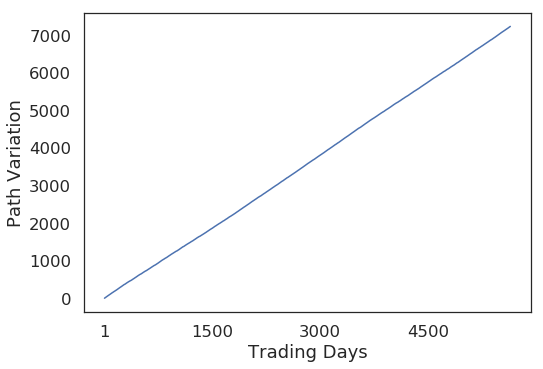

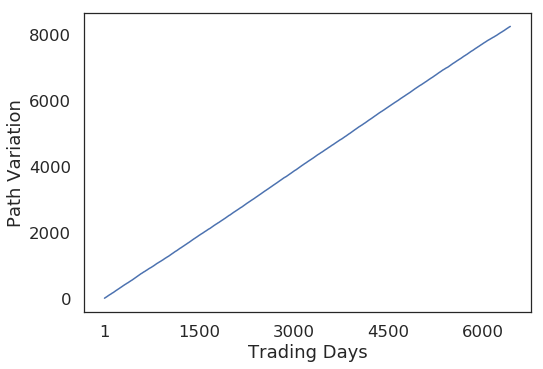

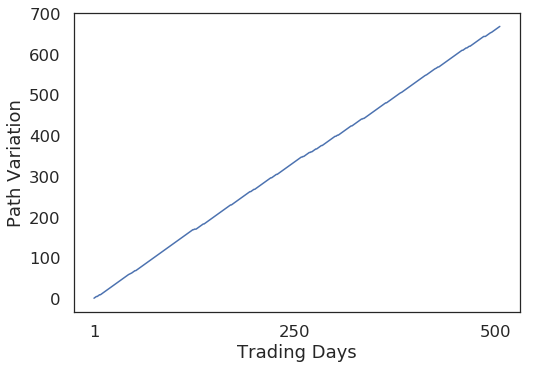

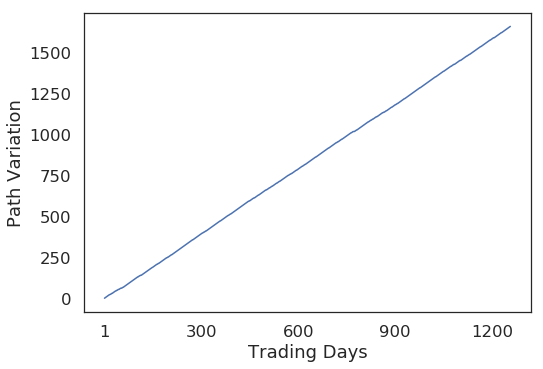

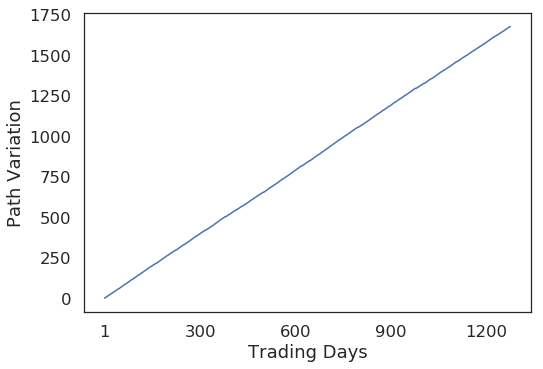

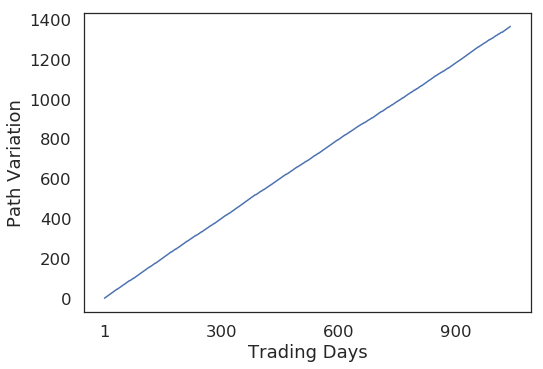

In [23]:
# variations = {}
# path_variations = {}
# xticks = {
#     'nyse-o': [1, 1500, 3000, 4500],
#     'nyse-n': [1, 1500, 3000, 4500, 6000],
#     'msci': [1, 300, 600, 900],
#     'tse': [1, 300, 600, 900, 1200],
#     'sp500': [1, 300, 600, 900, 1200],
#     'djia': [1, 250, 500],
# }

# for dataset in datasets:
#     variations[dataset] = []
#     X = all_data[dataset]
#     T = len(X)

#     for t in range(1, T):
#         r_cur = X[t] - 1
#         r_prev = X[t-1] - 1
#         variations[dataset].append(
#             np.linalg.norm(cv_weights(r_cur) - cv_weights(r_prev))
#         )
    
#     path_variations[dataset] = np.cumsum(variations[dataset])
    
#     fig, ax = plt.subplots()
#     plt.plot(path_variations[dataset])
#     plt.xlabel('Trading Days')
#     plt.ylabel('Path Variation')
#     plt.xticks(xticks[dataset])
# #     plt.plot([0, path_variations[dataset][-1]], [0, path_variations[dataset][-1]])

2019-05-30 17:40:25,164 Assigning font /F1 = u'/usr/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
2019-05-30 17:40:27,292 Embedding font /usr/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
2019-05-30 17:40:27,315 Writing TrueType font.
2019-05-30 17:40:30,308 Assigning font /F1 = u'/usr/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
2019-05-30 17:40:30,577 Embedding font /usr/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
2019-05-30 17:40:30,579 Writing TrueType font.
2019-05-30 17:40:31,573 Assigning font /F1 = u'/usr/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
2019-05-30 17:40:31,714 Embedding font /usr/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
2019-05-30 17:40:31,729 Writing TrueType font.
2019-05-30 17:40:32,379 Assigning font /F1 = u'/usr/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
2

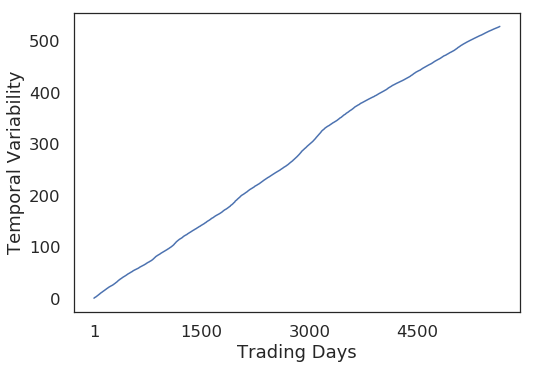

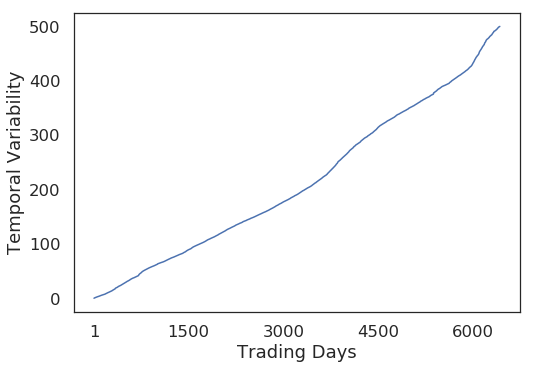

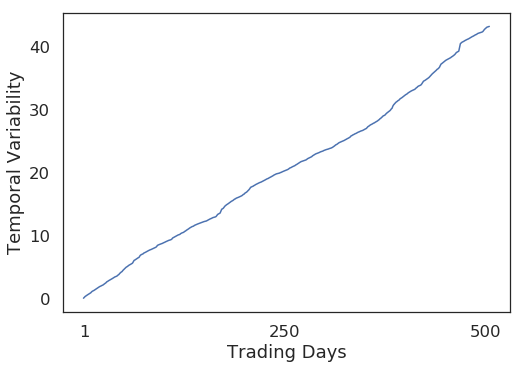

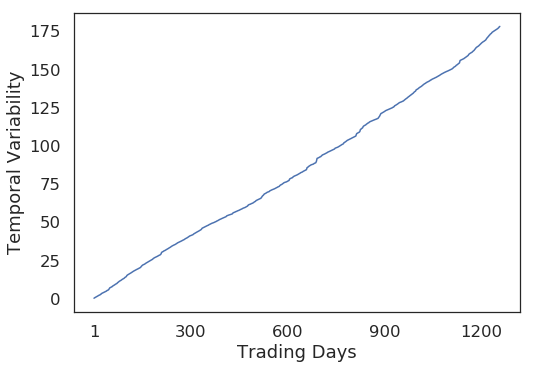

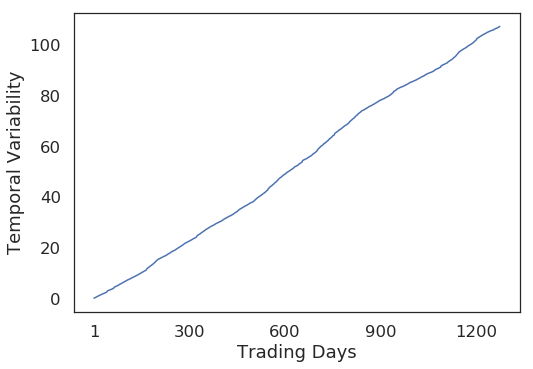

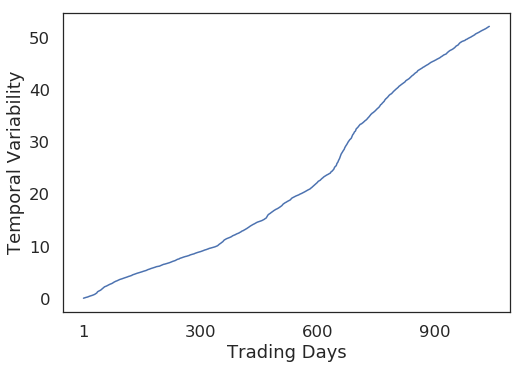

In [91]:
varfuns = {}
cumvarfuns = {}
xticks = {
    'nyse-o': [1, 1500, 3000, 4500],
    'nyse-n': [1, 1500, 3000, 4500, 6000],
    'msci': [1, 300, 600, 900],
    'tse': [1, 300, 600, 900, 1200],
    'sp500': [1, 300, 600, 900, 1200],
    'djia': [1, 250, 500],
}

for dataset in datasets:
    X = all_data[dataset]
    T = len(X)
    varfuns[dataset] = []
    
    for t in range(1, T):
        dX = X[t] - X[t-1]
        varfuns[dataset].append( max(np.abs(dX)) )
    
    cumvarfuns[dataset] = np.cumsum(varfuns[dataset])
    fig, ax = plt.subplots()
    plt.plot(cumvarfuns[dataset])
    plt.xlabel('Trading Days')
    plt.ylabel('Temporal Variability')
    plt.xticks(xticks[dataset])
#     plt.plot([0, cumvarfuns[dataset][-1]], [0, cumvarfuns[dataset][-1]])
    plt.savefig('../../figures/variation-functional_' + dataset + '.pdf')

2019-05-29 09:56:04,679 Assigning font /F1 = u'/usr/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
2019-05-29 09:56:04,757 Assigning font /F2 = u'/usr/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Oblique.ttf'
2019-05-29 09:56:05,611 Embedding font /usr/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Oblique.ttf.
2019-05-29 09:56:05,621 Writing TrueType font.
2019-05-29 09:56:05,709 Embedding font /usr/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
2019-05-29 09:56:05,713 Writing TrueType font.


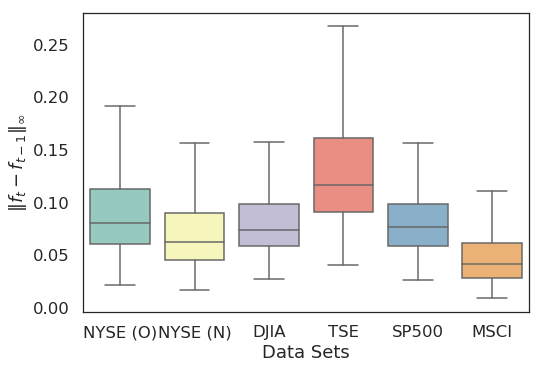

In [90]:
# fig, ax = plt.subplots()
# ax.boxplot(varfuns.values())
# ax.set_xticklabels(varfuns.keys())

all_varfuns = []

for dataset in datasets:
    all_varfuns.append(varfuns[dataset])

fig, ax = plt.subplots()
sns.boxplot(data = all_varfuns, showfliers = False, palette = 'Set3')
plt.xlabel('Data Sets')
plt.ylabel(r'$\Vert f_t - f_{t-1} \Vert_\infty$')
ax.set_xticklabels(['NYSE (O)', 'NYSE (N)', 'DJIA', 'TSE', 'SP500', 'MSCI'])

plt.savefig('../../figures/variation-functional-boxplot.pdf')

# Missing Benchmarks

In [5]:
class BestStock(Algo):

    PRICE_TYPE = 'raw'

    def __init__(self):
        super(BestStock, self).__init__()
        

    def weights(self, S):
        b = np.where(S.iloc[-1] == max(S.iloc[-1]), 1, 0)

        # weights are proportional to price times initial weights
        w = S * b

        # normalise
        w = w.div(w.sum(axis = 1), axis = 0)

        # shift
        w = w.shift(1)
        w.ix[0] = 1. / S.shape[1]

        return w

# Sanity Check

In [93]:
tw = pd.DataFrame(columns = datasets)
benchmarks = [
    algos.BAH(),
    BestStock(),
    algos.BCRP(),
    UP(),
    algos.EG(),
    algos.ONS(),
    BNN(),
    algos.CORN(),
    algos.Anticor(),
    algos.PAMR(),
    algos.CWMR(),
    algos.OLMAR(),
]

for b in benchmarks:
    for col in tw.columns:
        data = pd.DataFrame(prices[col]).astype(np.float64)
        r = b.run(data)
        tw.loc[b.__class__.__name__, col] = r.equity.iloc[-1]
        
print(tw)

Exception KeyboardInterrupt in 'zmq.backend.cython.message.Frame.__dealloc__' ignored


NameError: name 'UP' is not defined

**Problematic algos:**

- UP on NYSE_O, NYSE_N, SP500 and MSCI (still acceptable though)
- ONS on NYSE_O and NYSE_N (still acceptable though)
- BNN, CORN, Anticor: huge discrepancies everywhere!
- CWMR: only right on DJIA
- OLMAR: wrong everywhere!

# Fixing Erroneous Algos

In [6]:
class UP(Algo):
    """ Universal Portfolio by Thomas Cover enhanced for "leverage" (instead of just
        taking weights from a simplex, leverage allows us to stretch simplex to
        contain negative positions).

    Reference:
        T. Cover. Universal Portfolios, 1991.
        http://www-isl.stanford.edu/~cover/papers/paper93.pdf
    """

    PRICE = 'ratio'
    REPLACE_MISSING = False


    def __init__(self, eval_points=10000, leverage=1.):
        """
        :param eval_points: Number of evaluated points (approximately). Complexity of the
            algorithm is O(time * eval_points * nr_assets**2) because of matrix multiplication.
        :param leverage: Maximum leverage used. leverage == 1 corresponds to simplex,
            leverage == 1/nr_stocks to uniform CRP. leverage > 1 allows negative weights
            in portfolio.
        """
        super(UP, self).__init__()
        self.eval_points = eval_points
        self.leverage = leverage


    def init_weights(self, m):
        return np.ones(m) / m


    def init_step(self, X):
        """ Create a mesh on simplex and keep wealth of all strategies. """
        m = X.shape[1]

        # create set of CRPs
        self.W = np.matrix(tools.mc_simplex(m - 1, self.eval_points))
        self.S = np.matrix(np.ones(self.W.shape[0])).T

        # stretch simplex based on leverage (simple calculation yields this)
        leverage = max(self.leverage, 1./m)
        stretch = (leverage - 1./m) / (1. - 1./m)
        self.W = (self.W - 1./m) * stretch + 1./m


    def step(self, x, last_b):
        # calculate new wealth of all CRPs
        self.S = np.multiply(self.S, self.W * np.matrix(x).T)
        b = self.W.T * self.S

        return b / sum(b)


    def plot_leverage(self, S, leverage=np.linspace(1,10,10), **kwargs):
        """ Plot graph with leverages on x-axis and total wealth on y-axis.
        :param S: Stock prices.
        :param leverage: List of parameters for leverage.
        """
        wealths = []
        for lev in leverage:
            self.leverage = lev
            wealths.append(self.run(S).total_wealth)

        ax = pd.Series(wealths, index=leverage, **kwargs).plot(**kwargs)
        ax.set_xlabel('Leverage')
        ax.set_ylabel('Total Wealth')
        return ax
    
# nyse-o   nyse-n      djia      tse    sp500      msci
# UP  26.986  31.0157  0.811024  1.59612  1.63718  0.926912

In [7]:
class ONS(Algo):
    """
    Online newton step algorithm.

    Reference:
        A.Agarwal, E.Hazan, S.Kale, R.E.Schapire.
        Algorithms for Portfolio Management based on the Newton Method, 2006.
        http://machinelearning.wustl.edu/mlpapers/paper_files/icml2006_AgarwalHKS06.pdf
    """
    
    PRICE_TYPE = 'ratio'
    REPLACE_MISSING = False

    def __init__(self, delta=0.125, beta=1., eta=0.):
        """
        :param delta, beta, eta: Model parameters. See paper.
        """
        super(ONS, self).__init__()
        self.delta = delta
        self.beta = beta
        self.eta = eta


    def init_weights(self, m):
        return np.ones(m) / m


    def init_step(self, X):
        m = X.shape[1]
        self.A = np.mat(np.eye(m))
        self.b = np.mat(np.zeros(m)).T


    def step(self, r, p):
        # calculate gradient
        grad = np.mat(r / np.dot(p, r)).T
        # update A
        self.A += grad * grad.T
        # update b
        self.b += (1 + 1./self.beta) * grad

        # projection of p induced by norm A
        pp = self.projection_in_norm(self.delta * self.A.I * self.b, self.A)
        return pp * (1 - self.eta) + np.ones(len(r)) / float(len(r)) * self.eta

    def projection_in_norm(self, x, M):
        """ Projection of x to simplex indiced by matrix M. Uses quadratic programming.
        """
        m = M.shape[0]

        P = matrix(2*M)
        q = matrix(-2 * M * x)
        G = matrix(-np.eye(m))
        h = matrix(np.zeros((m,1)))
        A = matrix(np.ones((1,m)))
        b = matrix(1.)

        sol = solvers.qp(P, q, G, h, A, b)
        return np.squeeze(sol['x'])
    
#           nyse-o   nyse-n     djia      tse    sp500     msci
# ONS  109.276  21.4319  1.53233  1.61987  3.34365  0.85641

In [8]:
class OLMAR(Algo):

    PRICE_TYPE = 'raw'
    REPLACE_MISSING = False

    def __init__(self, window = 5, eps = 10):
        super(OLMAR, self).__init__(min_history = window)

        # input check
        if window < 2:
            raise ValueError('window parameter must be >=3')
        if eps < 1:
            raise ValueError('epsilon parameter must be >=1')

        self.window = window
        self.eps = eps


    def init_weights(self, m):
        return np.ones(m) / m


    def step(self, x, last_b, history):
        # calculate return prediction
        x_tilde = self.predict(x, history.iloc[-self.window:])
        b = self.update(last_b, x_tilde, self.eps)
        return b


    def predict(self, x, history):
        """ Predict returns on next day. """
        sma = history.mean()
        return sma / x


    def update(self, b, x, eps):
        x_bar = np.mean(x)
        lam = max(0., eps - np.dot(b, x)) / np.linalg.norm(x - x_bar)**2

        # update portfolio
        b += lam * (x - x_bar)

        # project it onto simplex
        return tools.simplex_proj(b)
    
#     nyse-o      nyse-n     djia      tse    sp500     msci
# OLMAR  7.87533e+16  4.2316e+08  2.25903  58.5904  16.3724  14.7158

In [9]:
import scipy.stats
from numpy.linalg import inv
from numpy import diag, sqrt, log, trace


class CWMR(Algo):
    """ Confidence weighted mean reversion.

    Reference:
        B. Li, S. C. H. Hoi, P.L. Zhao, and V. Gopalkrishnan.
        Confidence weighted mean reversion strategy for online portfolio selection, 2013.
        http://jmlr.org/proceedings/papers/v15/li11b/li11b.pdf
    """

    PRICE_TYPE = 'ratio'
    REPLACE_MISSING = False

    def __init__(self, eps=-0.5, confidence=0.95):
        """
        :param eps: Mean reversion threshold (expected return on current day must be lower
                    than this threshold). Recommended value is -0.5.
        :param confidence: Confidence parameter for profitable mean reversion portfolio.
                    Recommended value is 0.95.
        """
        super(CWMR, self).__init__()

        # input check
        if not (0 <= confidence <= 1):
            raise ValueError('confidence must be from interval [0,1]')

        self.eps = eps
        self.theta = scipy.stats.norm.ppf(confidence)


    def init_weights(self, m):
        return np.ones(m) / m


    def init_step(self, X):
        m = X.shape[1]
        self.sigma = np.matrix(np.eye(m) / m**2)


    def step(self, x, last_b):
        # initialize
        m = len(x)
        mu = np.matrix(last_b).T
        sigma = self.sigma
        theta = self.theta
        eps = self.eps
        x = np.matrix(x).T    # matrices are easier to manipulate

        # 4. Calculate the following variables
        M = mu.T * x
        V = x.T * sigma * x
        x_upper = sum(diag(sigma) * x) / trace(sigma)

        # 5. Update the portfolio distribution
        mu, sigma = self.update(x, x_upper, mu, sigma, M, V, theta, eps)

        # 6. Normalize mu and sigma
        mu = tools.simplex_proj(mu)
        sigma = sigma / (m**2 * trace(sigma))
        """
        sigma(sigma < 1e-4*eye(m)) = 1e-4;
        """
        self.sigma = sigma
        return mu

    def update(self, x, x_upper, mu, sigma, M, V, theta, eps):
        # lambda from equation 7
        foo = (V - x_upper * x.T * np.sum(sigma, axis=1)) / M**2 + V * theta**2 / 2.
        a = foo**2 - V**2 * theta**4 / 4
        b = 2 * (eps - log(M)) * foo
        c = (eps - log(M))**2 - V * theta**2

        a,b,c = a[0,0], b[0,0], c[0,0]

        lam = max(0,
                  (-b + sqrt(b**2 - 4 * a * c)) / (2. * a),
                  (-b - sqrt(b**2 - 4 * a * c)) / (2. * a))
        # bound it due to numerical problems
        lam = min(lam, 1E+7)

        # update mu and sigma
        U_sqroot = 0.5 * (-lam * theta * V + sqrt(lam**2 * theta**2 * V**2 + 4*V))
        mu = mu - lam * sigma * (x - x_upper) / M
        sigma = inv(inv(sigma) + theta * lam / U_sqroot * diag(x)**2)
        """
        tmp_sigma = inv(inv(sigma) + theta*lam/U_sqroot*diag(xt)^2);
        % Don't update sigma if results are badly scaled.
        if all(~isnan(tmp_sigma(:)) & ~isinf(tmp_sigma(:)))
            sigma = tmp_sigma;
        end
        """
        return mu, sigma



class CWMR_VAR(CWMR):
    """ First variant of a CWMR outlined in original article. It is
    only approximation to the posted problem. """

    def update(self, x, x_upper, mu, sigma, M, V, theta, eps):
        # lambda from equation 7
        foo = (V - x_upper * x.T * np.sum(sigma, axis=1)) / M**2
        a = 2 * theta * V * foo
        b = foo + 2 * theta * V * (eps - log(M))
        c = eps - log(M) - theta * V

        a,b,c = a[0,0], b[0,0], c[0,0]

        lam = max(0,
                  (-b + sqrt(b**2 - 4 * a * c)) / (2. * a),
                  (-b - sqrt(b**2 - 4 * a * c)) / (2. * a))
        # bound it due to numerical problems
        lam = min(lam, 1E+7)

        # update mu and sigma
        mu = mu - lam * sigma * (x - x_upper) / M
        sigma = inv(inv(sigma) + 2 * lam * theta * diag(x)**2)
        """
        tmp_sigma = inv(inv(sigma) + theta*lam/U_sqroot*diag(xt)^2);
        % Don't update sigma if results are badly scaled.
        if all(~isnan(tmp_sigma(:)) & ~isinf(tmp_sigma(:)))
            sigma = tmp_sigma;
        end
        """
        return mu, sigma
    
    
#            nyse-o      nyse-n      djia      tse    sp500     msci
# CWMR  5.54992e+15  1.3088e+06  0.679142  193.864  4.98003  14.9306

In [10]:
class PAMR(Algo):
    """ Passive aggressive mean reversion strategy for portfolio selection.
    There are three variants with different parameters, see original article
    for details.

    Reference:
        B. Li, P. Zhao, S. C.H. Hoi, and V. Gopalkrishnan.
        Pamr: Passive aggressive mean reversion strategy for portfolio selection, 2012.
        http://www.cais.ntu.edu.sg/~chhoi/paper_pdf/PAMR_ML_final.pdf
    """

    PRICE_TYPE = 'ratio'
    REPLACE_MISSING = False

    def __init__(self, eps=0.5, C=500, variant=0):
        """
        :param eps: Control parameter for variant 0. Must be >=0, recommended value is
                    between 0.5 and 1.
        :param C: Control parameter for variant 1 and 2. Recommended value is 500.
        :param variant: Variants 0, 1, 2 are available.
        """
        super(PAMR, self).__init__(min_history = 1)

        # input check
        if not(eps >= 0):
            raise ValueError('epsilon parameter must be >=0')

        if variant == 0:
            if eps is None:
                raise ValueError('eps parameter is required for variant 0')
        elif variant == 1 or variant == 2:
            if C is None:
                raise ValueError('C parameter is required for variant 1,2')
        else:
            raise ValueError('variant is a number from 0,1,2')

        self.eps = eps
        self.C = C
        self.variant = variant


    def init_weights(self, m):
        return np.ones(m) / m


    def step(self, x, last_b):
        # calculate return prediction
        b = self.update(last_b, x, self.eps, self.C)
        return b


    def update(self, b, x, eps, C):
        """ Update portfolio weights to satisfy constraint b * x <= eps
        and minimize distance to previous weights. """
        x_mean = np.mean(x)
        le = max(0., np.dot(b, x) - eps)

        if self.variant == 0:
            lam = le / np.linalg.norm(x - x_mean)**2
        elif self.variant == 1:
            lam = min(C, le / np.linalg.norm(x - x_mean)**2)
        elif self.variant == 2:
            lam = le / (np.linalg.norm(x - x_mean)**2 + 0.5 / C)

        # limit lambda to avoid numerical problems
        lam = min(100000, lam)

        # update portfolio
        b = b - lam * (x - x_mean)

        # project it onto simplex
        return tools.simplex_proj(b)

In [11]:
# tw = pd.DataFrame(columns = datasets)
# alg = PAMR()

# for dataset in datasets:
#     data = pd.DataFrame(prices[dataset]).astype(np.float64)
#     r = alg.run(data)
#     tw.loc[alg.__class__.__name__, dataset] = r.equity.iloc[-1]
        
# print(tw)

# OLMAX: Online Maximum Reversion

In [12]:
class SingleOLMAX(Algo):
    
    PRICE_TYPE = 'ratio'
    REPLACE_MISSING = False
    
    def __init__(self):
        super(SingleOLMAX, self).__init__()


    def init_weights(self, n):
        return np.ones(n) / n


    def step(self, x, last_w):
        x_min = min(x)
        
        if x_min < 1:
            return np.where(x == x_min, 1, 0)
        
        return np.zeros(len(x))

In [13]:
class MultiOLMAX(Algo):
    
    PRICE_TYPE = 'raw'
    REPLACE_MISSING = False
    
    def __init__(self, window = 5):
        super(MultiOLMAX, self).__init__(min_history = window)

        # input check
        if window < 3:
            raise ValueError('window parameter must be >=3')
        
        self.window = window


    def init_weights(self, n):
        return np.ones(n) / n


    def step(self, x, last_w, history):
        # calculate return prediction
        x_tilde = self.predict(x, history.iloc[-self.window:])
        return self.update(x_tilde)


    def predict(self, x, history):
        """ Predict returns on next day. """
        sma = history.mean()
        return sma / x

    
    def update(self, x):
        x_max = max(x)
        
        if x_max > 1:
            return np.where(x == x_max, 1, 0)
        
        return np.zeros(len(x))

In [14]:
class MultiOLMAX2(Algo):
    
    PRICE_TYPE = 'raw'
    REPLACE_MISSING = False
    
    def __init__(self, alpha = 0.3):
        super(MultiOLMAX2, self).__init__()
        
        self.alpha = alpha
        self.ema = 0.


    def init_weights(self, n):
        return np.ones(n) / n


    def step(self, x, last_w):
        # calculate return prediction
        x_tilde = self.predict(x)
        return self.update(x_tilde)


    def predict(self, x):
        """ Predict returns on next day. """
#         x_tilde = self.ema / x
#         self.ema = self.alpha * x + (1-self.alpha) * self.ema
#         return x_tilde
        self.ema = self.alpha * x + (1-self.alpha) * self.ema
        return self.ema / x

    
    def update(self, x):
        x_max = max(x)
        
        if x_max > 1:
            return np.where(x == x_max, 1, 0)
        
        return np.zeros(len(x))

In [15]:
# dataset = 'djia'

# algs = [
# #     SingleOLMAX(),
#     MultiOLMAX(),
#     MultiOLMAX2(alpha = 0.3),
# #     algos.OLMAR()
# ]
# labels = [a.__class__.__name__ for a in algs]
# res = {}

# res[labels[0]] = algs[0].run(pd.DataFrame(prices[dataset]).astype(np.float64))
# ax = res[labels[0]].plot(
#     logy = True, assets = False, weights = False, portfolio_label = labels[0]
# )

# for i in range(1, len(algs)):
#     res[labels[i]] = algs[i].run(pd.DataFrame(prices[dataset]).astype(np.float64))
#     res[labels[i]].plot(
#         logy = True, assets = False, weights = False,
#         ax = ax[0],  portfolio_label = labels[i]
#     )

# MAPGRAD

In [16]:
class MAPGRAD(Algo):
    
    PRICE_TYPE = 'ratio'
    REPLACE_MISSING = False
    
    def __init__(self, demean = True):
        super(MAPGRAD, self).__init__(min_history = 1)

        self.demean = demean
        self.gradsum = 0.
        
        
    def init_weights(self, n):
        return np.ones(n) / n


    def step(self, x, last_w):
        # compute gradient
        if not self.demean:
            r = x.values - 1
            rp = np.dot(last_w, r)
            g = r / (1 + rp)
        elif self.demean:
            g = x / np.dot(last_w, x)
            g -= np.mean(g)
        
        # update gradient sum
        self.gradsum += g
        
        # compute learning rate
        eta = len(x) / np.linalg.norm(self.gradsum)**2
        
        # update weights
        w = last_w - eta * g
        
        return tools.simplex_proj(w)

# PAMR Enhancements

In [17]:
class AdaPAMR(Algo):
    """
    Adaptive passive-aggressive mean reversion strategy for portfolio selection.
    """
    
    PRICE_TYPE = 'ratio'
    REPLACE_MISSING = False

    def __init__(self, demean = True):
        super(AdaPAMR, self).__init__(min_history = 1)

        self.demean = demean
        self.gradsum = 0.


    def init_weights(self, m):
        return np.ones(m) / m


    def step(self, x, last_b):
        return self.update(last_b, x)


    def update(self, b, x):
        # compute gradient
        if not self.demean:
            r = x.values - 1
            g = r
        elif self.demean:
            g = x
            g -= np.mean(g)
        
        # update gradient sum
        self.gradsum += g
        
        # update learning rate
        eta = len(x) / np.linalg.norm(self.gradsum)**2

        # update portfolio
        b -= eta * g

        # project it onto simplex
        return tools.simplex_proj(b)

# OLMAR Enhancements

In [18]:
class AdaOLMAR(Algo):
    """
    Adaptive On-Line Portfolio Selection with Moving Average Reversion
    """

    PRICE_TYPE = 'raw'
    REPLACE_MISSING = False

    def __init__(self, window = 5, demean = True):
        """
        :param window: Lookback window.
        """

        super(AdaOLMAR, self).__init__(min_history = window)

        # input check
        if window < 3:
            raise ValueError('window parameter must be >=3')

        self.window = window
        self.demean = demean
        self.gradsum = 0.


    def init_weights(self, m):
        return np.ones(m) / m


    def step(self, x, last_b, history):
        # calculate return prediction
        x_tilde = self.predict(x, history.iloc[-self.window:])
        b = self.update(last_b, x_tilde)
        return b


    def predict(self, x, history):
        """ Predict returns on next day. """
        sma = history.mean()
        return sma / x


    def update(self, b, x):
        # compute gradient
        if not self.demean:
            r = x.values - 1
            g = r
        elif self.demean:
            g = x
            g -= np.mean(g)
            
        # update gradient sum
        self.gradsum += g
        
        # compute learning rate
        eta = len(x) / np.linalg.norm(self.gradsum)**2

        # update portfolio
        b += eta * g

        # project it onto simplex
        return tools.simplex_proj(b)

In [19]:
# dataset = 'msci'

# data = pd.DataFrame(prices[dataset]).astype(np.float64)
# algs = [
#     SingleOLMAX(),
#     MultiOLMAX(),
#     MAPGRAD(),
#     AdaPAMR(),
#     AdaOLMAR(),
#     PAMR(),
#     OLMAR(),
# ]
# res = {}

# label = algs[0].__class__.__name__
# res[label] = algs[0].run(data)
# ax = res[label].plot(
#     logy = True, assets = False, weights = False, ucrp = True, portfolio_label = label
# )

# for alg in algs[1:]:
#     label = alg.__class__.__name__
#     res[label] = alg.run(data)
#     res[label].plot(
#         logy = True, assets = False, weights = False, ucrp = False, portfolio_label = label, ax = ax[0]
#     )
#     res[label].fee = 0.001

# Online Maximum Sharpe

In [20]:
# class OLMAS(Algo):

#     PRICE_TYPE = 'ratio'
#     REPLACE_MISSING = False

#     def __init__(self, window = 3):
#         super(OLMAS, self).__init__(min_history = window)

#         # input check
#         if window < 2:
#             raise ValueError('window parameter must be >=3')

#         self.window = window
#         self.gradsum = 0.


#     def init_weights(self, m):
#         return np.ones(m) / m


#     def step(self, x, last_b, history):
#         R = history.iloc[-self.window:] - 1
        
#         # update frequency
#         freq = tools.freq(R.index)
        
#         # calculate mean and covariance matrix and annualise them
#         mu = R.mean()
#         Sigma = R.cov()
        
#         # update portfolio
#         b = self.update(last_b, mu, Sigma)
#         return b
    

#     def update(self, b, mu, Sigma):
#         ret = np.dot(b, mu)
#         vol = np.sqrt( np.dot(b, np.dot(Sigma, b)) )
        
#         # compute gradient
#         g = (vol**2) * mu - ret * np.dot(Sigma, b)
#         g /= vol**3
        
#         # update gradient sum
#         self.gradsum += g
        
#         # compute learning rate
#         eta = len(b) / np.linalg.norm(self.gradsum)**2
#         eta = min(10**5, eta)

#         # update portfolio
#         b -= eta * g

#         # project it onto simplex
#         return tools.simplex_proj(b)
    

# algo = OLMAS()
# result = algo.run(datasets['nyse_o'])

# print(result.summary())
# result.plot(ucrp = True, logy = True, assets = False, weights = False)

# Performance Comparison

In [111]:
olps = {}

for dataset in datasets:
    olps_algos = [
        algos.BAH(),
        BestStock(),
        algos.BCRP(),
        UP(),
        algos.EG(),
        ONS(),
    #     algos.Anticor(),
        # missing: B^K,
    #     BNN(),
    #     algos.CORN(),
        PAMR(),
        CWMR(),
        OLMAR(),
        SingleOLMAX(),
        MultiOLMAX(),
#         MAPGRAD(),
#         AdaPAMR(),
#         AdaOLMAR(),
        MultiOLMAX2(alpha = 0.3),
    ]
    algo_names = [algo.__class__.__name__ for algo in olps_algos]
    olps[dataset] = pd.DataFrame(index = algo_names)
    data = pd.DataFrame(prices[dataset]).astype(np.float64)
    for name, algo in zip(algo_names, olps_algos):
        olps[dataset].ix[name, 'results'] = algo.run(data)

2019-06-01 09:39:06,872 Running BAH...
2019-06-01 09:39:15,008 BAH finished successfully.
/usr/lib/python2.7/site-packages/ipykernel_launcher.py:29: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
2019-06-01 09:39:16,227 Running BestStock...
/usr/lib/python2.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
2019-06-01 09:39:16,307 BestStock finished successfully.
2019-06-01 09:39:16,605 Running BCRP...
2019-06-01 09:39:17,799 BCRP finished successfully.
2019-06-01 09:39:18,047 Running UP...
2019-06-01 09:39:18,966 Progress: 0%...
2019-06-01 09:39:20,648 Progress: 10%...
2019-06-01 09:39:22,308 Pro

In [112]:
# W = 30

# windows = range(3, W + 1)
# for dataset in datasets:
#     data = pd.DataFrame(prices[dataset]).astype(np.float64)
#     olmax_algos = [MultiOLMAX(w) for w in windows]
#     olmax_equity = pd.DataFrame()
#     for i in range(len(windows)):
#         result = olmax_algos[i].run(data)
#         olmax_equity['w = ' + str(windows[i])] = result.equity
#     bah = algos.BAH()
#     olps[dataset].ix['BAH(MultiOLMAX-S)', 'results'] = bah.run(olmax_equity)

## Terminal wealth table

In [113]:
terminal_wealth_table = pd.DataFrame(index = algo_names, columns = datasets)
# for name in algo_names + ['BAH(MultiOLMAX-S)']:
for name in algo_names:
    for dataset in datasets:
#         olps[dataset].results[name].fee = 0.001
        terminal_wealth_table.loc[name, dataset] = round(
            olps[dataset].results[name].equity.iloc[-1], 2
        )

print(terminal_wealth_table)

                  nyse-o       nyse-n  djia      tse  sp500   msci
BAH                 14.5        18.06  0.76     1.61   1.34   0.91
BestStock          54.14        83.51  1.19     6.28   3.78    1.5
BCRP               250.6       120.32  1.24     6.78   4.07   1.51
UP                 27.04        31.13  0.81      1.6   1.63   0.93
EG                 27.09           31  0.81     1.59   1.63   0.93
ONS               109.28        21.43  1.53     1.62   3.34   0.86
PAMR         5.13843e+15   1.2526e+06  0.68   264.86   5.09  15.23
CWMR         5.54992e+15   1.3088e+06  0.68   193.86   4.98  14.93
OLMAR        7.87533e+16   4.2316e+08  2.26    58.59  16.37  14.72
SingleOLMAX  4.08501e+15       508569  0.59  1557.71   8.32    7.3
MultiOLMAX   4.33262e+16  3.38991e+08   2.6    75.88  15.15   8.87
MultiOLMAX2  2.49976e+18  4.83978e+08  1.27    300.5  14.78  12.44


In [25]:
number = 1557.71
print("{:.2e}".format(number))

1.56e+03


## Cumulative wealth plots

In [26]:
# subalgos = [
#     algos.BAH(),
#     algos.BCRP(),
#     algos.Anticor(),
#     algos.BNN(),
#     algos.CORN(),
#     algos.PAMR(),
#     algos.CWMR(),
#     algos.OLMAR(),
#     MaxReversion(),
#     MAPGRAD(),
#     AdaPAMR(),
#     AdaOLMAR(),
# ]

# subalgo_names = [algo.__class__.__name__ for algo in subalgos]
# print(subalgo_names)

# colors = {
#     'BAH': 'red',
#     'BCRP': 'lime',
#     'Anticor': 'mediumblue',
#     'BNN': 'fuchsia',
#     'CORN': 'cyan',
#     'PAMR': 'bisque',
#     'CWMR': 'grey',
#     'OLMAR': 'brown',
#     'MaxReversion': 'purple',
#     'MAPGRAD': 'yellow',
#     'AdaPAMR': 'black',
#     'AdaOLMAR': 'darkorange',
# }

# # colors = sns.color_palette('Paired')

# f, ax = plt.subplots(figsize = (18, 8))
# ax.set_ylabel('Total Wealth Achieved')
# ax.set_xlabel('Trading Days')

# for symbol in ['tse']:
#     logy = True if symbol in ['nyse_o', 'nyse_n', 'tse', 'sp500'] else False
#     for k, r in olps[symbol].results.iteritems():
#         if k not in subalgo_names:
#             continue
#         r.plot(logy = logy, assets = False, weights = False,
#                color = colors[k], portfolio_label = k, ax = ax)

## Statistical tests

In [27]:
import statsmodels.api as sm

RET_RF = 1.000156
olmax_label = 'MultiOLMAX2'

stat_tests = pd.DataFrame(columns = datasets)

for dataset in datasets:
    bah_res = olps[dataset].results['BAH']
    olmax_res = olps[dataset].results[olmax_label]
    
    stat_tests.loc['Size', dataset] = len(bah_res.r) - 1
    
    bah_excess_rets = bah_res.equity.pct_change().fillna(0).values - RET_RF + 1
    olmax_excess_rets = olmax_res.equity.pct_change().fillna(0).values - RET_RF + 1
    stat_tests.loc['MER (OLMAX)', dataset] = np.mean(olmax_excess_rets)
    stat_tests.loc['MER (Market)', dataset] = np.mean(bah_excess_rets)
    
    stat_tests.loc['Winning Ratio', dataset] = olmax_res.winning_pct

    X = sm.add_constant(bah_excess_rets)
    y = olmax_excess_rets
    ols = sm.OLS(y, X)
    ols_res = ols.fit()
    stat_tests.loc['alpha', dataset] = ols_res.params[0]
    stat_tests.loc['beta', dataset] = ols_res.params[1]
    stat_tests.loc['t-stat', dataset] = ols_res.tvalues[0]
    stat_tests.loc['p-value', dataset] = ols_res.pvalues[0]
    
print(stat_tests)

                    nyse-o       nyse-n         djia          tse  \
Size                  5651         6431          507         1259   
MER (OLMAX)     0.00799654   0.00362575  0.000863778    0.0061111   
MER (Market)   0.000360967   0.00035779   -0.0005677  0.000257109   
Winning Ratio     0.588638     0.554573     0.518219     0.565378   
alpha           0.00752475   0.00321762   0.00158826   0.00568658   
beta               1.30701      1.14068      1.27618      1.65115   
t-stat             16.6374      7.52869      1.35033      3.40411   
p-value        1.02027e-60  5.82806e-14     0.177514  0.000684697   

                     sp500         msci  
Size                  1276         1043  
MER (OLMAX)     0.00256681   0.00257205  
MER (Market)   0.000190321 -0.000129791  
Winning Ratio     0.533225     0.560949  
alpha           0.00231671   0.00272312  
beta                1.3141      1.16391  
t-stat             2.86699      5.06679  
p-value         0.00421217  4.78386e-07  


## Risk-adjusted returns

In [28]:
subalgos = ['BAH', 'BCRP', 'CORN', 'Anticor', 'PAMR', 'CWMR', 'OLMAR', 'MultiOLMAX']
colors = ['red', 'lime', 'mediumblue', 'fuchsia', 'cyan', 'yellow', 'black', 'darkorange']
xlabels = ['NYSE (O)', 'NYSE (N)', 'TSE', 'SP500', 'MSCI', 'DJIA']
new_datasets = ['nyse-o', 'nyse-n', 'tse', 'sp500', 'msci', 'djia']

# colors = {algo: color for algo, color in zip(subalgos, tones)}

([<matplotlib.axis.YTick at 0x7f276503c790>,
 <a list of 6 Text yticklabel objects>)

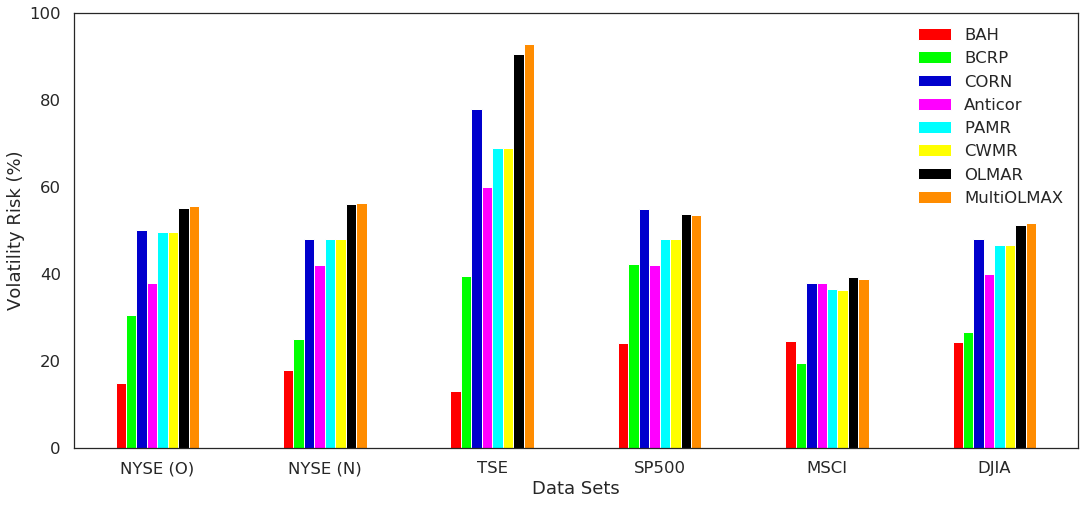

In [29]:
from matplotlib.ticker import AutoMinorLocator

corn_vols = {
    'nyse-o': 0.5,
    'nyse-n': 0.48,
    'tse': 0.78,
    'sp500': 0.55,
    'msci': 0.38,
    'djia': 0.48
}

anticor_vols = {
    'nyse-o': 0.38,
    'nyse-n': 0.42,
    'tse': 0.60,
    'sp500': 0.42,
    'msci': 0.38,
    'djia': 0.40
}

vols = pd.DataFrame(index = new_datasets, columns = subalgos)

for dataset in new_datasets:
    for algo in subalgos:
        if algo == 'Anticor':
            vols.loc[dataset, 'Anticor'] = anticor_vols[dataset]
        elif algo == 'CORN':
            vols.loc[dataset, 'CORN'] = corn_vols[dataset]
        else:
            vols.loc[dataset, algo] = olps[dataset].results[algo].volatility

vols.index = xlabels
vols *= 100

# minor_locator = AutoMinorLocator(2)
# ax.xaxis.set_minor_locator(minor_locator)

vols.plot.bar(x = vols.index, figsize = (18, 8), color = colors)
plt.xticks(rotation = 0)
plt.xlabel('Data Sets')
plt.ylabel('Volatility Risk (%)')
plt.yticks(range(0, 120, 20))

([<matplotlib.axis.YTick at 0x7f2764d547d0>,
 <a list of 6 Text yticklabel objects>)

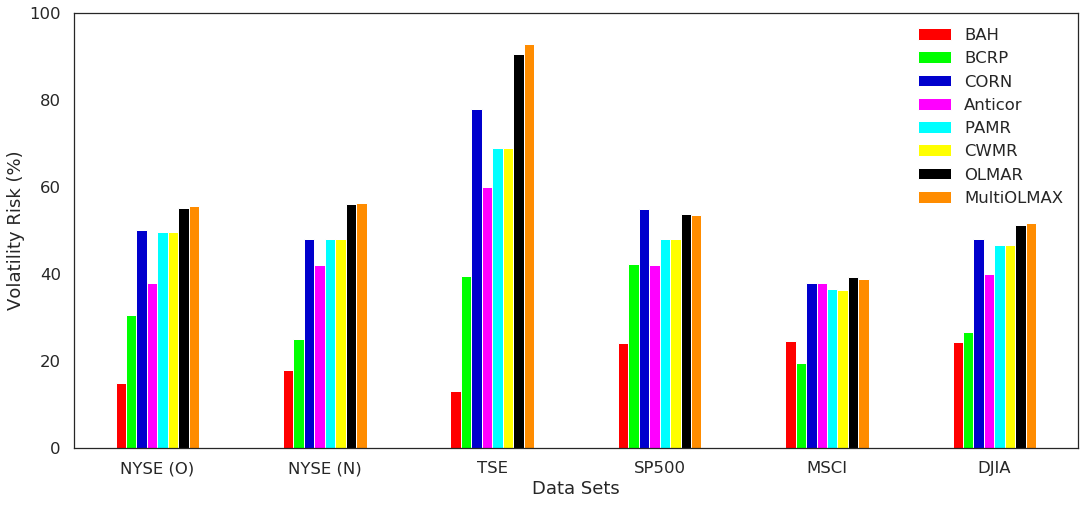

In [30]:
from matplotlib.ticker import AutoMinorLocator

corn_vols = {
    'nyse-o': 0.5,
    'nyse-n': 0.48,
    'tse': 0.78,
    'sp500': 0.55,
    'msci': 0.38,
    'djia': 0.48
}

anticor_vols = {
    'nyse-o': 0.38,
    'nyse-n': 0.42,
    'tse': 0.60,
    'sp500': 0.42,
    'msci': 0.38,
    'djia': 0.40
}

vols = pd.DataFrame(index = new_datasets, columns = subalgos)

for dataset in new_datasets:
    for algo in subalgos:
        if algo == 'Anticor':
            vols.loc[dataset, 'Anticor'] = anticor_vols[dataset]
        elif algo == 'CORN':
            vols.loc[dataset, 'CORN'] = corn_vols[dataset]
        else:
            vols.loc[dataset, algo] = olps[dataset].results[algo].volatility

vols.index = xlabels
vols *= 100

# minor_locator = AutoMinorLocator(2)
# ax.xaxis.set_minor_locator(minor_locator)

vols.plot.bar(x = vols.index, figsize = (18, 8), color = colors)
plt.xticks(rotation = 0)
plt.xlabel('Data Sets')
plt.ylabel('Volatility Risk (%)')
plt.yticks(range(0, 120, 20))

In [31]:
vols

,BAH,BCRP,CORN,Anticor,PAMR,CWMR,OLMAR,MultiOLMAX
NYSE (O),14.8427,30.4624,50,38,49.724,49.6612,55.2334,55.5813
NYSE (N),17.9819,24.9058,48,42,48.0978,47.9829,56.175,56.3401
TSE,13.045,39.4976,78,60,68.9077,68.918,90.5805,92.7487
SP500,24.2009,42.3567,55,42,48.0101,48.0526,53.6513,53.6099
MSCI,24.6707,19.5149,38,38,36.4235,36.3978,39.3266,38.7801
DJIA,24.3195,26.6578,48,40,46.5315,46.5906,51.1496,51.6852


# ETF Backtests

In [183]:
swensen_allocation = [0.3, 0.15, 0.1, 0.15, 0.15, 0.15]
benchmark = ['SPY']

olps_algos = [
    algos.BAH(),
    BestStock(),
    algos.BCRP(),
    algos.CRP(b=swensen_allocation),
    UP(),
    algos.EG(),
    ONS(),
#     algos.Anticor(),
    # missing: B^K,
#     BNN(),
#     algos.CORN(),
    PAMR(),
    CWMR(),
    OLMAR(),
    SingleOLMAX(),
    MultiOLMAX(),
    MultiOLMAX2(alpha = 0.3),
#     MAPGRAD(demean = False),
    AdaPAMR(demean = False),
    AdaOLMAR(demean = False),
]

algo_names = [algo.__class__.__name__ for algo in olps_algos]
algo_data = [
    'algo', 'results', 'profit', 'sharpe', 'information', 'annualized_return',
    'drawdown_period', 'winning_pct', 'vol', 'mdd']
metrics = algo_data[2:]
etf_olps = pd.DataFrame(index=algo_names, columns=algo_data)
etf_olps.algo = olps_algos

# run all algos - this takes more than a minute
for name, algo in zip(etf_olps.index, etf_olps.algo):
    etf_olps.ix[name,'results'] = algo.run(S)

2019-06-04 23:27:49,278 Running BAH...
2019-06-04 23:27:49,289 BAH finished successfully.
/usr/lib/python2.7/site-packages/ipykernel_launcher.py:36: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
2019-06-04 23:27:49,313 Running BestStock...
/usr/lib/python2.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
2019-06-04 23:27:49,327 BestStock finished successfully.
2019-06-04 23:27:49,342 Running BCRP...
2019-06-04 23:27:49,453 BCRP finished successfully.
2019-06-04 23:27:49,504 Running CRP...
2019-06-04 23:27:49,524 CRP finished successfully.
2019-06-04 23:27:49,556 Running UP...
2019-06-04 23:27:4

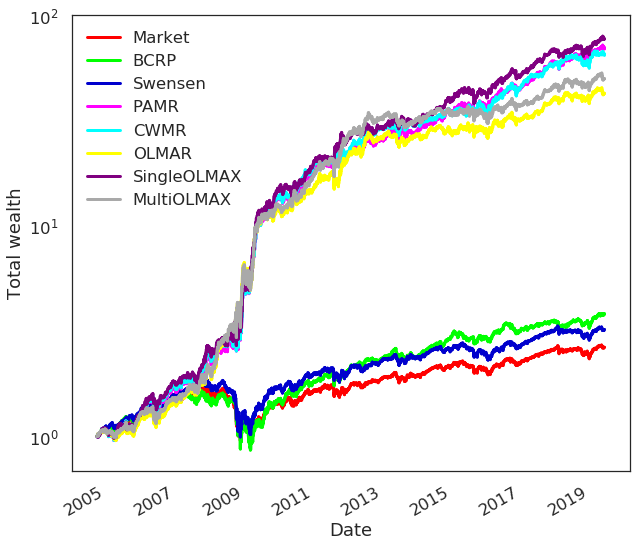

In [218]:
subalgos = [
    algos.BAH(),
    algos.BCRP(),
    algos.CRP(b=swensen_allocation),
    PAMR(),
    CWMR(),
    OLMAR(),
    SingleOLMAX(),
    MultiOLMAX(),
#     AdaOLMAR(),
#     AdaPAMR(),
]

subalgo_names = [algo.__class__.__name__ for algo in subalgos]

colors = {
    'Market': 'red',
    'BCRP': 'lime',
    'Swensen': 'mediumblue',
    'PAMR': 'fuchsia',
    'CWMR': 'cyan',
    'OLMAR': 'yellow',
    'SingleOLMAX': 'purple',
    'MultiOLMAX': 'darkgrey',
    'AdaOLMAR': 'black',
    'AdaPAMR': 'darkorange',
}

f, ax = plt.subplots(figsize = (10, 9.3))

for k, r in etf_olps.results.iteritems():
    if k not in subalgo_names:
        continue
    if k == 'BAH':
        k = 'Market'
    if k == 'CRP':
        k = 'Swensen'
    r.fee = 0.00
    r.plot(logy = True, assets = False, weights = False, color = colors[k], portfolio_label = k, ax = ax)

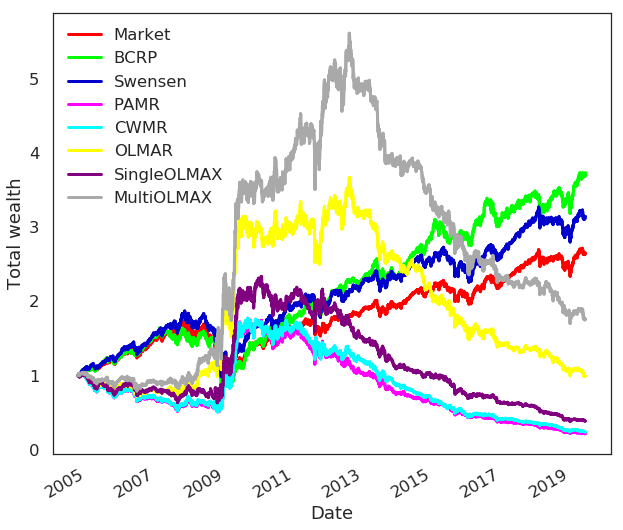

In [190]:
f, ax = plt.subplots(figsize = (10, 9))

for k, r in etf_olps.results.iteritems():
    if k not in subalgo_names:
        continue
    if k == 'BAH':
        k = 'Market'
    if k == 'CRP':
        k = 'Swensen'
    r.fee = 0.001
    r.plot(assets = False, weights = False, color = colors[k], portfolio_label = k, ax = ax)

In [219]:
epsvals = np.logspace(0, 3, 10)
epsvals = [int(x) for x in epsvals]
cumwealths = []

for eps in epsvals:
    olmar = OLMAR(eps = eps, window = 5)
    r = olmar.run(S)
    r.fee = 0.001
    cumwealths.append(r.total_wealth)

df = pd.DataFrame()
df[r'$\epsilon$'] = epsvals
df['Total Wealth Achieved'] = cumwealths
f, ax = plt.subplots(figsize = (10, 7))
g = sns.barplot(x = r'$\epsilon$', y = 'Total Wealth Achieved', data = df, palette = "Blues_d")
g.figure.get_axes()[0].set_yscale('log')

ValueError: Length of values does not match length of index

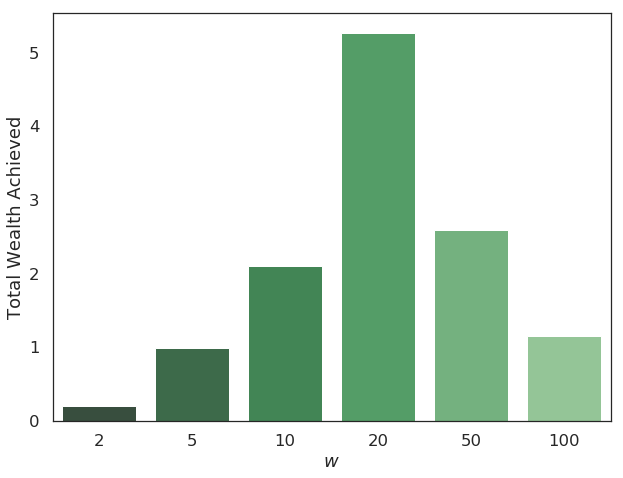

In [222]:
# windows = [2, 5, 10, 20, 50, 100]
# cumwealths = []

# for w in windows:
#     olmar = OLMAR(eps = 10, window = w)
#     r = olmar.run(S)
#     r.fee = 0.001
#     cumwealths.append(r.total_wealth)

# df = pd.DataFrame()
# df[r'$w$'] = windows
# df['Total Wealth Achieved'] = cumwealths
f, ax = plt.subplots(figsize = (10, 7.5))
g = sns.barplot(x = r'$w$', y = 'Total Wealth Achieved', data = df, palette = "Greens_d")
# g.figure.get_axes()[0].set_yscale('log')

2019-06-04 16:12:33,653 Running OLMAR...
2019-06-04 16:12:34,579 Progress: 10%...
2019-06-04 16:12:35,619 Progress: 20%...
2019-06-04 16:12:36,616 Progress: 30%...
2019-06-04 16:12:37,597 Progress: 40%...
2019-06-04 16:12:38,610 Progress: 50%...
2019-06-04 16:12:39,559 Progress: 60%...
2019-06-04 16:12:40,537 Progress: 70%...
2019-06-04 16:12:41,519 Progress: 80%...
2019-06-04 16:12:42,469 Progress: 90%...
2019-06-04 16:12:43,413 OLMAR finished successfully.


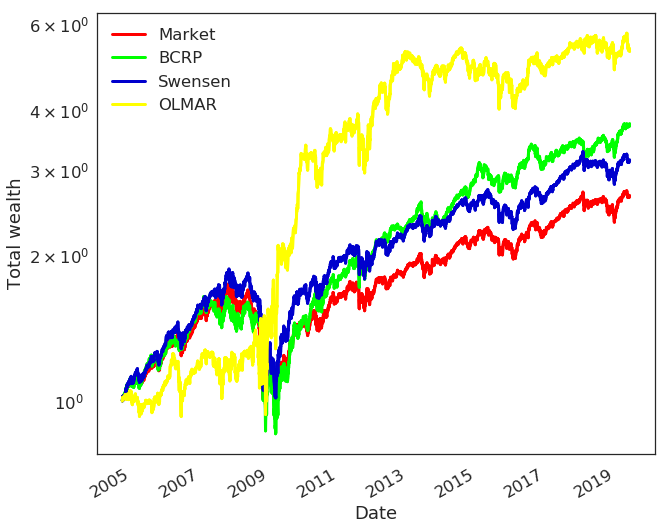

In [167]:


f, ax = plt.subplots(figsize = (10, 9))

for k, r in etf_olps.results.iteritems():
    if k not in ['BAH', 'BCRP', 'CRP']:
        continue
    if k == 'BAH':
        k = 'Market'
    if k == 'CRP':
        k = 'Swensen'
    r.fee = 0.001
    r.plot(logy = True, assets = False, weights = False, color = colors[k], portfolio_label = k, ax = ax)
    
alg = OLMAR(window=20, eps=10)
r = alg.run(S)

r.fee = 0.001
r.plot(assets = False, weights = False, logy = True, color = colors['OLMAR'], portfolio_label = 'OLMAR', ax = ax)

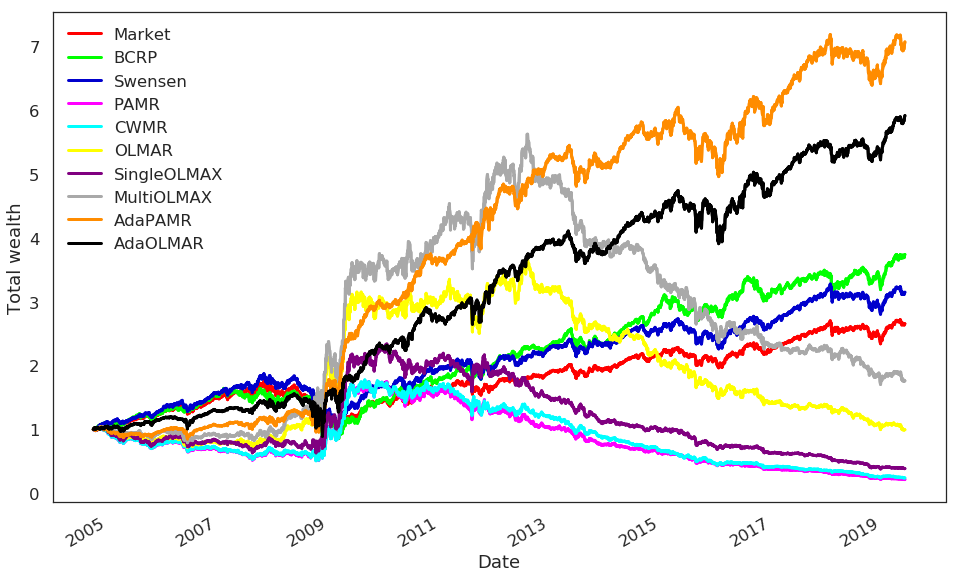

In [191]:
subalgos = [
    algos.BAH(),
    algos.BCRP(),
    algos.CRP(b=swensen_allocation),
    PAMR(),
    CWMR(),
    OLMAR(),
    SingleOLMAX(),
    MultiOLMAX(),
    AdaOLMAR(),
    AdaPAMR(),
]

subalgo_names = [algo.__class__.__name__ for algo in subalgos]

colors = {
    'Market': 'red',
    'BCRP': 'lime',
    'Swensen': 'mediumblue',
    'PAMR': 'fuchsia',
    'CWMR': 'cyan',
    'OLMAR': 'yellow',
    'SingleOLMAX': 'purple',
    'MultiOLMAX': 'darkgrey',
    'AdaOLMAR': 'black',
    'AdaPAMR': 'darkorange',
}

f, ax = plt.subplots(figsize = (16, 10))

for k, r in etf_olps.results.iteritems():
    if k not in subalgo_names:
        continue
    if k == 'BAH':
        k = 'Market'
    if k == 'CRP':
        k = 'Swensen'
    r.fee = 0.001
    r.plot(assets = False, weights = False, color = colors[k], portfolio_label = k, ax = ax)

In [232]:
def olps_stats(df):
    for name, r in df.results.iteritems():
        r.fee = 0.001
        df.ix[name,'profit'] = r.profit_factor
        df.ix[name,'sharpe'] = r.sharpe
        df.ix[name,'information'] = r.information
        df.ix[name,'annualized_return'] = r.annualized_return * 100
        df.ix[name,'drawdown_period'] = r.drawdown_period
        df.ix[name,'winning_pct'] = r.winning_pct * 100
        df.ix[name,'vol'] = r.volatility * 100
        df.ix[name,'mdd'] = r.max_drawdown * 100
    return df

In [233]:
olps_stats(etf_olps)
submetrics = ['annualized_return', 'vol', 'mdd', 'sharpe']
etf_olps[submetrics]

,annualized_return,vol,mdd,sharpe
BAH,6.87248,14.895765,45.3302,0.446209
BestStock,8.83158,18.472007,55.4538,0.45816
BCRP,9.39267,18.813482,47.971,0.477178
CRP,8.11784,17.334698,47.305,0.450262
UP,7.73816,14.609210,42.0433,0.510182
EG,7.83392,14.607905,41.7181,0.51631
ONS,10.1373,15.217960,32.6411,0.634495
PAMR,-9.95364,24.541155,87.7391,-0.427224
CWMR,-9.28918,24.753488,86.5415,-0.393858
OLMAR,-0.0402961,24.873249,73.0973,-0.00162039
